In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution


def calculate_coverage_and_overlap(square_centers, image_mask, square_size):
    """Calculates coverage and overlap for given square centers."""
    image_height, image_width = image_mask.shape
    coverage_mask = np.zeros_like(image_mask, dtype=np.uint8)
    squares = []

    x_min = np.clip(
        square_centers[:, 0] - square_size / 2, 0, image_width - square_size
    ).astype(int)
    y_min = np.clip(
        square_centers[:, 1] - square_size / 2, 0, image_height - square_size
    ).astype(int)
    x_max = x_min + square_size
    y_max = y_min + square_size

    for i in range(len(square_centers)):
        if (
            square_size / 2 <= square_centers[i, 0] < image_width - square_size / 2
            and square_size / 2 <= square_centers[i, 1] < image_height - square_size / 2
        ):
            coverage_mask[y_min[i] : y_max[i], x_min[i] : x_max[i]] = 1
            squares.append((x_min[i], y_min[i], x_max[i], y_max[i]))

    covered_area = np.sum(np.logical_and(image_mask, coverage_mask))
    overlap_area = np.sum(coverage_mask) - len(squares) * square_size * square_size
    used_squares = len(squares)

    return covered_area, overlap_area, used_squares


def square_coverage_optimization(
    image_mask,
    square_size,
    max_squares,
    coverage_weight=-1,
    overlap_weight=0.001,
    unused_weight=10,
    popsize=50,
    maxiter=100,
    tol=0.01,
):
    """Optimizes square placement with early stopping and returns the best solution."""

    image_height, image_width = image_mask.shape
    best_solution = None
    best_cost = float("inf")

    def cost_function(individual):
        """Calculates the cost and updates the best solution."""
        nonlocal best_cost, best_solution
        square_centers = np.array(individual).reshape((max_squares, 2))
        covered_area, overlap_area, used_squares = calculate_coverage_and_overlap(
            square_centers, image_mask, square_size
        )

        cost = (
            coverage_weight * covered_area
            + overlap_weight * overlap_area
            + unused_weight * (max_squares - used_squares)
        )

        if cost < best_cost:
            best_cost = cost
            best_solution = square_centers.copy()

        return cost

    bounds = [
        (square_size / 2, image_width - square_size / 2),
        (square_size / 2, image_height - square_size / 2),
    ] * max_squares

    result = differential_evolution(
        cost_function,
        bounds,
        popsize=popsize,
        maxiter=maxiter,
        tol=tol,
    )

    if result.success or best_solution is not None:
        if best_solution is None:
            best_solution = np.array(result.x).reshape((max_squares, 2))
        valid_squares = [
            (int(x - square_size / 2), int(y - square_size / 2))
            for x, y in best_solution
            if (
                square_size / 2 <= x < image_width - square_size / 2
                and square_size / 2 <= y < image_height - square_size / 2
            )
        ]
        return valid_squares
    else:
        print("Optimization failed:", result.message)
        return None

In [71]:
# toy problem
image = np.zeros((200, 200), dtype=np.uint8)
cv2.circle(image, (100, 100), 50, 255, -1)
cv2.rectangle(image, (20, 20), (80, 80), 255, -1)
cv2.rectangle(image, (120, 120), (180, 180), 255, -1)
mask = np.zeros_like(image)
mask[image == 255] = 1

# 2. Set parameters
# 1/4 the size an edge
square_size = image.shape[0] // 4
# proportional to the mask total
max_squares = int(mask.sum() // (square_size**2))
print("Square size:", square_size)
print("Max squares:", max_squares)
coverage_weight = -1  # Adjust these weights as needed
overlap_weight = 0.01
unused_weight = 10

# 3. Optimize square placement
square_locations = square_coverage_optimization(
    mask,
    square_size,
    max_squares,
    coverage_weight,
    overlap_weight,
    unused_weight,
    popsize=20,
    maxiter=500,
    tol=0.01,
)
print("Square locations:", square_locations)
print("Number of squares:", len(square_locations))

Square size: 50
Max squares: 5
Square locations: [(20, 24), (69, 49), (55, 98), (105, 80), (121, 131)]
Number of squares: 5


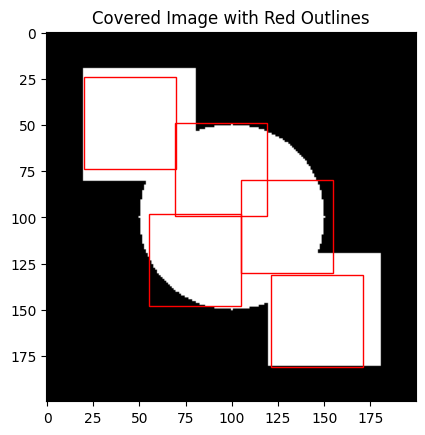

In [72]:
plt.imshow(image, cmap="gray")  # Display the image mask
for x, y in square_locations:
    rect = plt.Rectangle(
        (x, y), square_size, square_size, linewidth=1, edgecolor="r", facecolor="none"
    )  # red outlines
    plt.gca().add_patch(rect)
plt.title("Covered Image with Red Outlines")
plt.show()

In [58]:
# let's try this with a real mask
from plantclef.spark import get_spark
from pathlib import Path
from pyspark.sql import functions as F
import numpy as np
from plantclef.serde import deserialize_mask, serialize_mask

spark = get_spark(cores=4)


@F.udf("binary")
def merge_masks(masks: list[bytearray]) -> bytearray:
    masks = [deserialize_mask(m) for m in masks]
    merged = np.bitwise_or.reduce(masks)
    return serialize_mask(merged)


root = Path("~/shared/plantclef/data").expanduser().as_posix()
masks = spark.read.parquet(f"{root}/masking/test_2024_v2/data")

combined_mask = (
    masks.unpivot(
        "image_name", [c for c in masks.columns if "mask" in c], "mask_type", "mask"
    )
    .where(F.col("mask_type").isin(["plant_mask", "flower_mask", "leaf_mask"]))
    .groupBy("image_name")
    .agg(F.collect_list("mask").alias("masks"))
    .select("image_name", merge_masks(F.col("masks")).alias("mask"))
).cache()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/03 04:56:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/03 04:56:20 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


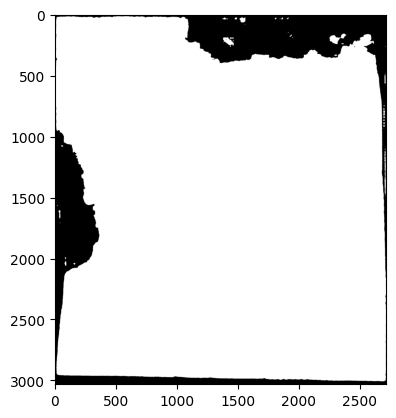

In [73]:
row = combined_mask.first()

mask = deserialize_mask(row.mask)
plt.imshow(mask, cmap="gray")

In [ ]:
def optimize_and_plot(row, grid_size=5):
    mask = deserialize_mask(row.mask)
    square_size = mask.shape[0] // grid_size
    # proportional to the mask total
    max_squares = int(mask.sum() // (square_size**2))
    print("Square size:", square_size)
    print("Max squares:", max_squares)
    coverage_weight = -1  # Adjust these weights as needed
    overlap_weight = 0.01
    unused_weight = 10

    # 3. Optimize square placement
    square_locations = square_coverage_optimization(
        mask,
        square_size,
        max_squares,
        coverage_weight,
        overlap_weight,
        unused_weight,
        popsize=20,
        maxiter=500,
        tol=0.01,
    )
    print("Square locations:", square_locations)
    print("Number of squares:", len(square_locations))
    plt.imshow(image, cmap="gray")  # Display the image mask
    for x, y in square_locations:
        rect = plt.Rectangle(
            (x, y),
            square_size,
            square_size,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )  # red outlines
        plt.gca().add_patch(rect)
    plt.title(f"{row.image_name} - {len(square_locations)} squares")
    plt.show()


optimize_and_plot(row)

Square size: 606
Max squares: 19
